In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_selection import f_regression, mutual_info_regression

In [9]:
salary_df = pd.read_csv('Salary.csv')

## 预测薪酬 Model Building

### 1. 查看数据结构和预处理

In [10]:
# 查看数据基本信息
print(salary_df.info())

# 显示前几行数据
salary_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6684 entries, 0 to 6683
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  6684 non-null   float64
 1   Gender               6684 non-null   object 
 2   Education Level      6684 non-null   int64  
 3   Job Title            6684 non-null   object 
 4   Years of Experience  6684 non-null   float64
 5   Salary               6684 non-null   float64
 6   Country              6684 non-null   object 
 7   Race                 6684 non-null   object 
 8   Senior               6684 non-null   int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 470.1+ KB
None


,Age,Gender,Education Level,Job Title,Years of Experience,Salary,Country,Race,Senior
0,32.0,Male,1,Software Engineer,5.0,90000.0,UK,White,0
1,28.0,Female,2,Data Analyst,3.0,65000.0,USA,Hispanic,0
2,45.0,Male,3,Manager,15.0,150000.0,Canada,White,1
3,36.0,Female,1,Sales Associate,7.0,60000.0,USA,Hispanic,0
4,52.0,Male,2,Director,20.0,200000.0,USA,Asian,0


### 2. 特征选择

In [41]:
# 选取特征和目标变量
target = 'Salary'
numerical_cols = salary_df.select_dtypes(include=['float64', 'int64']).drop(columns=[target]).columns
categorical_cols = salary_df.select_dtypes(include='object').columns

#### 2.1 数值特征相关性分析（F-test）

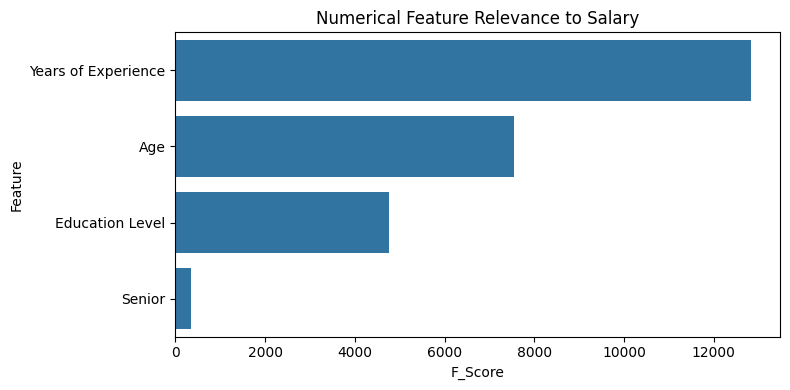

In [ ]:
X_num = salary_df[numerical_cols]
y = salary_df[target]

f_scores, _ = f_regression(X_num, y)
num_scores_df = pd.DataFrame({'Feature': numerical_cols, 'F_Score': f_scores})
top_num_features = num_scores_df.sort_values(by='F_Score', ascending=False).head(5)['Feature'].tolist()

# Visualization
plt.figure(figsize=(8, 4))
sns.barplot(data=num_scores_df.sort_values(by='F_Score', ascending=False), x='F_Score', y='Feature')
plt.title('Numerical Feature Relevance to Salary')
plt.tight_layout()
plt.show()

In [56]:
# 选择 F_Score 排名前 3 的数值型特征
top_3_f_score_num_features = num_scores_df.sort_values(by='F_Score', ascending=False).head(3)['Feature'].tolist()

print("Top 3 numerical features based on F_Score:")
print(top_3_f_score_num_features)

Top 3 numerical features based on F_Score:
['Years of Experience', 'Age', 'Education Level']


#### 2.1 数值特征相关性分析（相关系数）

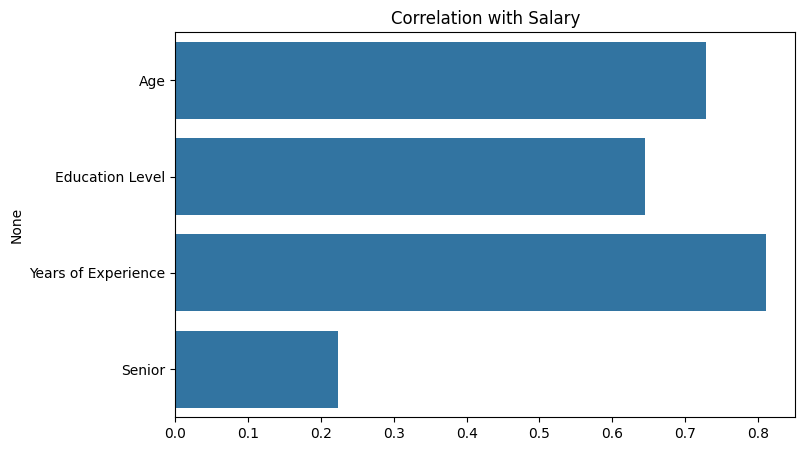

In [52]:
# 数值型特征
numerical_features = salary_df[numerical_cols]
correlations = numerical_features.corrwith(salary_df['Salary'])

# 可视化
plt.figure(figsize=(8, 5))
sns.barplot(x=correlations.values, y=correlations.index)
plt.title('Correlation with Salary')
plt.show()

In [57]:
# 选择绝对相关系数大于某个阈值的特征，图中阈值可以是0.3
#X_selected_num = numerical_features.loc[:, correlations.abs() > 0.3]

# 计算相关系数
correlations = numerical_features.corrwith(salary_df['Salary']).abs()

# 选择前 3 个相关性最高的特征
top_3_corr_num_features = correlations.sort_values(ascending=False).head(3).index.tolist()

print("Top 3 numerical features based on correlation with Salary:")
print(top_3_corr_num_features)

Top 3 numerical features based on correlation with Salary:
['Years of Experience', 'Age', 'Education Level']


In [58]:
top_num_features = top_3_corr_num_features

#### 2.2 分类特征与Salary的相关性（Mutual Information）

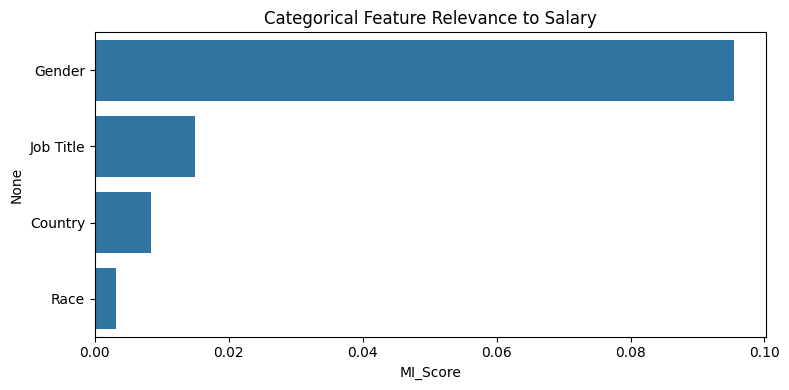

In [ ]:
mi_scores = {}

for col in categorical_cols:
    encoded = pd.get_dummies(salary_df[col], drop_first=True)
    score = mutual_info_regression(encoded, y)
    mi_scores[col] = score.mean()

cat_scores_df = pd.DataFrame.from_dict(mi_scores, orient='index', columns=['MI_Score'])
top_cat_features = cat_scores_df.sort_values(by='MI_Score', ascending=False).head(5).index.tolist()

# Visualization
plt.figure(figsize=(8, 4))
sns.barplot(data=cat_scores_df.sort_values(by='MI_Score', ascending=False).head(10), x='MI_Score', y=cat_scores_df.index)
plt.title('Categorical Feature Relevance to Salary')
plt.tight_layout()
plt.show()

### 3. Train-test split

In [59]:
selected_features = top_num_features + top_cat_features
X = salary_df[selected_features]
y = salary_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 4. Preprocessing pipeline 特征编码+标准化

In [60]:
# Redefine feature types for preprocessing
numerical_selected = [col for col in top_num_features if col in X.columns]
categorical_selected = [col for col in top_cat_features if col in X.columns]

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_selected),
    ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_selected)
])

### 5. Full ML Pipeline

In [61]:
model_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('model', LinearRegression())
])

# Train model
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Years of Experience', 'Age',
                                                   'Education Level']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Gender', 'Job Title',
                                                   'Country', 'Race'])])),
                ('model', LinearRegression())])

### 6. Evaluate model

/Users/zhangcao/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


MAE: 16522.05
RMSE: 22245.89
R²: 0.82


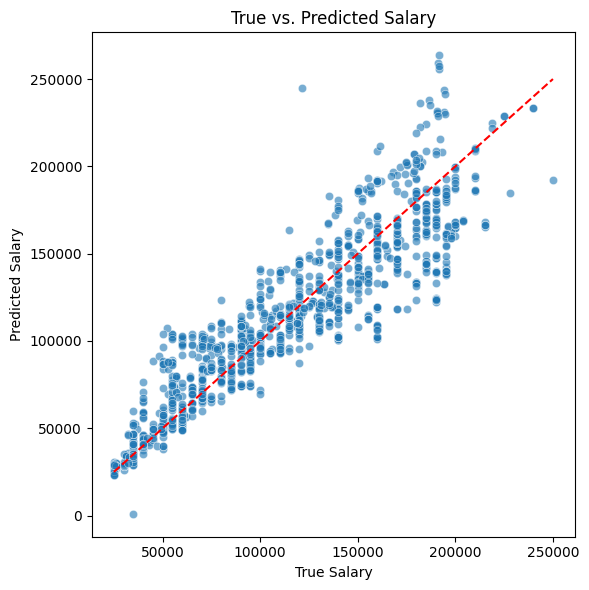

In [62]:
y_pred = model_pipeline.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

# Visualize prediction vs true values
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True Salary")
plt.ylabel("Predicted Salary")
plt.title("True vs. Predicted Salary")
plt.tight_layout()
plt.show()


### 用一个方程来构建并对比多个模型

In [63]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate_model(model_name, model, preprocessor, X_train, X_test, y_train, y_test):
    pipeline = Pipeline([
        ('preprocess', preprocessor),
        ('model', model)
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"\n📊 {model_name} Performance")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²: {r2:.2f}")

    # Plot predicted vs. true
    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("True Salary")
    plt.ylabel("Predicted Salary")
    plt.title(f"{model_name} - True vs. Predicted Salary")
    plt.tight_layout()
    plt.show()
    
    return {
        'Model': model_name,
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2
    }


/Users/zhangcao/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(



📊 Linear Regression Performance
MAE: 16522.05
RMSE: 22245.89
R²: 0.82


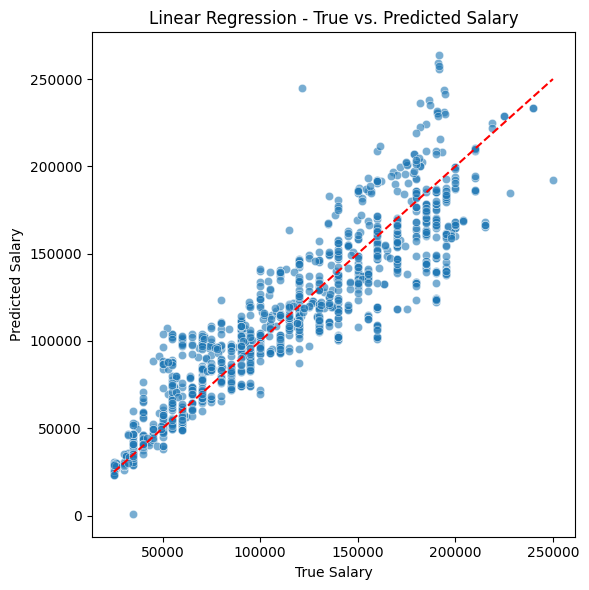

/Users/zhangcao/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(



📊 Random Forest Performance
MAE: 3970.59
RMSE: 8824.45
R²: 0.97


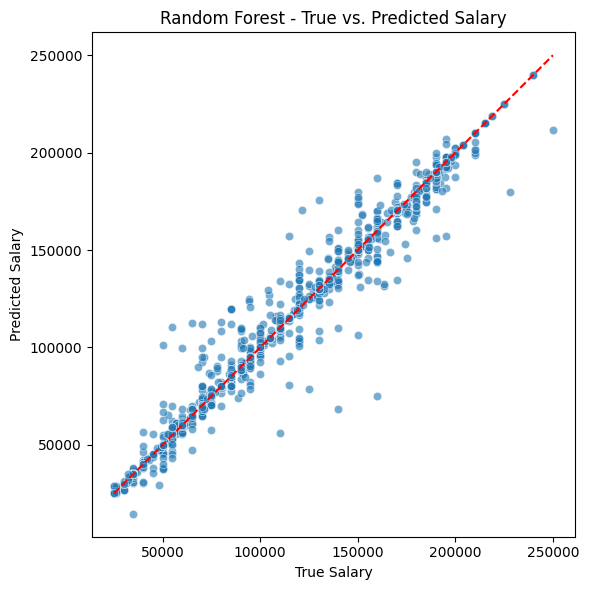

/Users/zhangcao/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(



📊 XGBoost Performance
MAE: 7296.18
RMSE: 10969.25
R²: 0.96


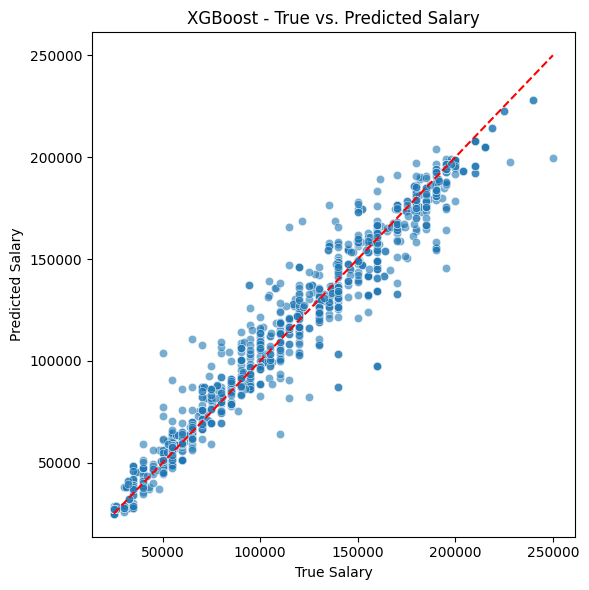

In [64]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

results = []

# Run Linear Regression
results.append(evaluate_model("Linear Regression", LinearRegression(), preprocessor, X_train, X_test, y_train, y_test))

# Run Random Forest
results.append(evaluate_model("Random Forest", RandomForestRegressor(n_estimators=100, random_state=42), preprocessor, X_train, X_test, y_train, y_test))

# Run XGBoost
results.append(evaluate_model("XGBoost", XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42), preprocessor, X_train, X_test, y_train, y_test))

### 对比模型结果


📋 Model Comparison Summary
               Model           MAE          RMSE        R2
0  Linear Regression  16522.050729  22245.887502  0.821916
1      Random Forest   3970.586542   8824.450793  0.971978
2            XGBoost   7296.177210  10969.254204  0.956701


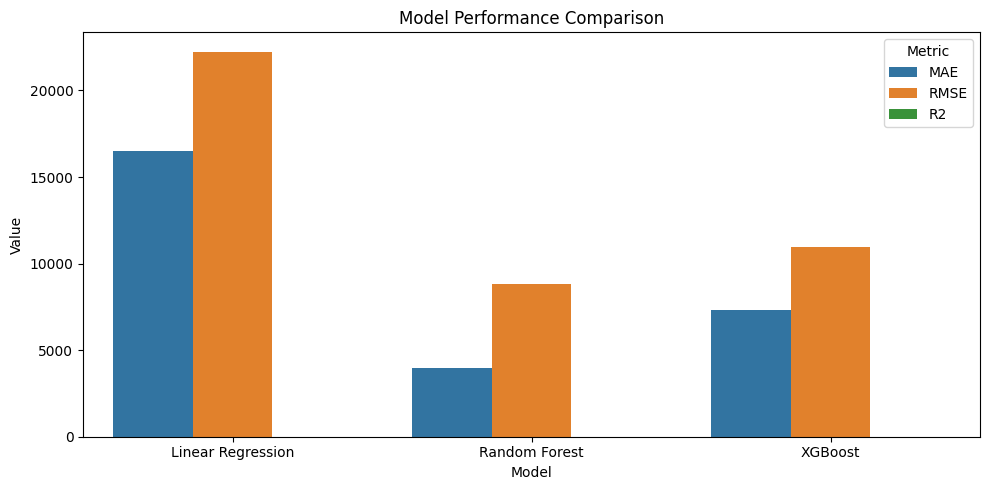

In [65]:
results_df = pd.DataFrame(results)

# Print comparison table
print("\n📋 Model Comparison Summary")
print(results_df)

# Visualization
plt.figure(figsize=(10, 5))
results_melted = results_df.melt(id_vars='Model', value_vars=['MAE', 'RMSE', 'R2'], var_name='Metric', value_name='Value')
sns.barplot(data=results_melted, x='Model', y='Value', hue='Metric')
plt.title("Model Performance Comparison")
plt.tight_layout()
plt.show()


### 7. 生成新数据不包含Salary

In [66]:
import numpy as np
import pandas as pd

# Example: Generate 5 new synthetic samples
synthetic_data = pd.DataFrame({
    'Age': np.random.randint(22, 60, size=5),
    'Gender': np.random.choice(['Male', 'Female'], size=5),
    'Education Level': np.random.choice([1, 2, 3], size=5),
    'Job Title': np.random.choice(salary_df['Job Title'].unique(), size=5),
    'Years of Experience': np.round(np.random.uniform(1, 30, size=5), 1),
    'Country': np.random.choice(salary_df['Country'].unique(), size=5),
    'Race': np.random.choice(salary_df['Race'].unique(), size=5),
    'Senior': np.random.choice([0, 1], size=5)
})

print("🆕 Synthetic Input Data:")
print(synthetic_data)


🆕 Synthetic Input Data:
   Age  Gender  Education Level                 Job Title  \
0   47    Male                3  Sales Operations Manager   
1   47  Female                2       Project Coordinator   
2   49    Male                1            Data Scientist   
3   41    Male                3              Receptionist   
4   36  Female                2        Principal Engineer   

   Years of Experience    Country              Race  Senior  
0                 10.4        USA             Black       1  
1                  9.5     Canada             Black       1  
2                 12.4     Canada           Chinese       0  
3                 24.6  Australia            Korean       0  
4                 12.2        USA  African American       1  


### 用同样的 Preprocessor 构建 Random Forest Model

In [67]:
rf_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])
rf_pipeline.fit(X_train, y_train)  # This should already be done before


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Years of Experience', 'Age',
                                                   'Education Level']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Gender', 'Job Title',
                                                   'Country', 'Race'])])),
                ('model', RandomForestRegressor(random_state=42))])

### 用Random Forest Model预测Salary

In [68]:
# Predict salaries for synthetic data
predicted_salaries = rf_pipeline.predict(synthetic_data)

# Add predictions to the DataFrame
synthetic_data['Predicted Salary'] = predicted_salaries

print("\n💰 Synthetic Data with Predicted Salaries:")
print(synthetic_data)


💰 Synthetic Data with Predicted Salaries:
   Age  Gender  Education Level                 Job Title  \
0   47    Male                3  Sales Operations Manager   
1   47  Female                2       Project Coordinator   
2   49    Male                1            Data Scientist   
3   41    Male                3              Receptionist   
4   36  Female                2        Principal Engineer   

   Years of Experience    Country              Race  Senior  Predicted Salary  
0                 10.4        USA             Black       1         109950.00  
1                  9.5     Canada             Black       1         109300.00  
2                 12.4     Canada           Chinese       0         127810.00  
3                 24.6  Australia            Korean       0         178080.08  
4                 12.2        USA  African American       1         137084.41  


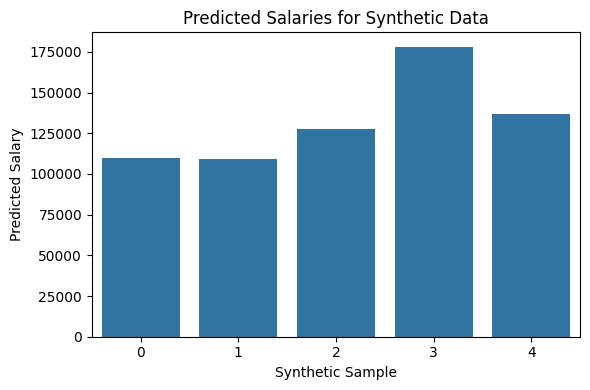

In [69]:
# Plot predicted salaries
plt.figure(figsize=(6, 4))
sns.barplot(x=synthetic_data.index, y=synthetic_data['Predicted Salary'])
plt.title("Predicted Salaries for Synthetic Data")
plt.xlabel("Synthetic Sample")
plt.ylabel("Predicted Salary")
plt.tight_layout()
plt.show()
